## Loading an ARG in tree sequence format

In [1]:
import tskit

In [2]:
ts = tskit.load("data/demo.trees")

In a notebook, we can show a tabular summary of the tree sequence file by displaying it to screen. Note that the [provenances](https://tskit.dev/tskit/docs/stable/provenance.html) listed in the second table below record how this ARG was originally generated (in this case, initially simulated by the [msprime](https://tskit.dev/msprime/docs/stable/intro.html) command `sim_ancestry`).

In [3]:
ts

## Analysis 

Below are a few examples of analysing the loaded _tskit_ ARG. Feel free to change them and re-run the cells. Documentation for the methods is here: https://tskit.dev/tskit/docs/stable/python-api.html (e.g. see [here](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.allele_frequency_spectrum) for the allele frequency spectrum).

In [4]:
# Calculate the unpolarised allele frequency spectrum
afs = ts.allele_frequency_spectrum(polarised=False)
print(f"AFS calculated for {ts.num_samples} genomes of length {ts.sequence_length/1e6:.2f} Mb")

AFS calculated for 80 genomes of length 1.00 Mb


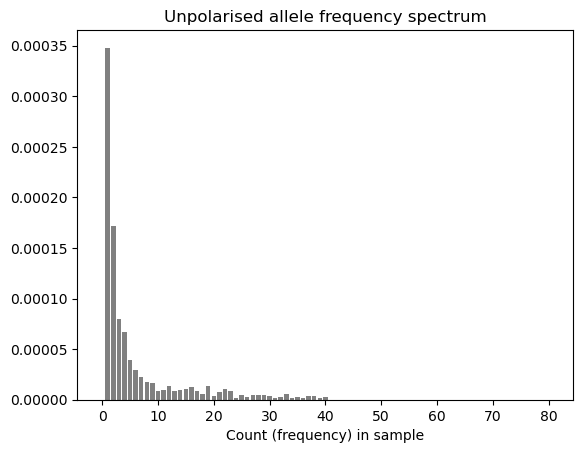

In [5]:
# and plot it
from matplotlib import pyplot as plt

plt.bar(range(ts.num_samples + 1), afs, color="grey")
plt.xlabel("Count (frequency) in sample")
plt.title("Unpolarised allele frequency spectrum");

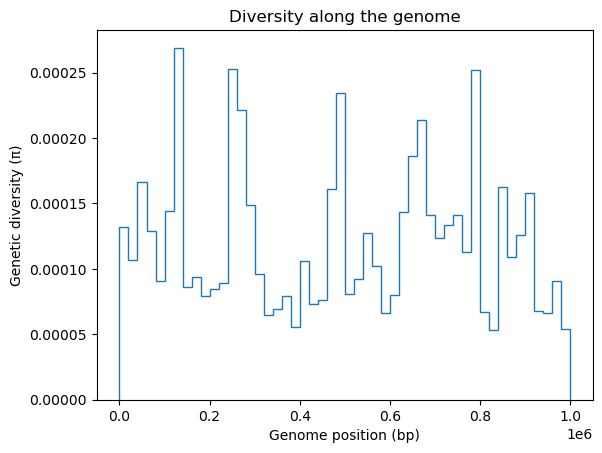

In [6]:
# Calculate windowed genetic diversity
genome_windows = list(range(0, int(ts.sequence_length+1), 20_000))  # or `np.linspace(0, ts.sequence_length, 51)`
windowed_diversity = ts.diversity(windows=genome_windows)
plt.stairs(windowed_diversity, genome_windows)
plt.ylabel("Genetic diversity (π)")
plt.xlabel("Genome position (bp)")
plt.title("Diversity along the genome");


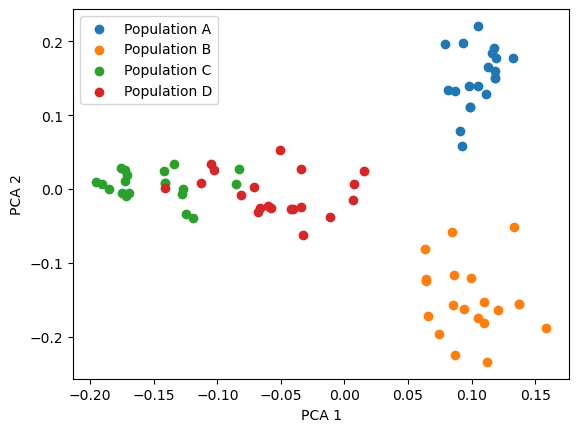

In [7]:
# Calculate the first 2 principle components for every haploid genome
# For a more conventional PCA of diploid individuals, use the `individuals` argument)

pca_output = ts.pca(2, mode="branch", random_seed=42)  # or add `individuals=range(ts.num_individuals)`

# Plot the PCA
for pop in ts.populations():
    use = ts.samples(population=pop.id)  # `use = ts.individual_populations == pop.id` if using individuals
    if use.any():
        plt.scatter(*pca_output.factors[use, :].T, label=f'Population {pop.metadata["name"]}')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend();

_Tskit_ has built-in tools for calculating coalescence and cross-coalescence rates. Below you can see that there is no coalescence between populations A and B more recently than 250 generations ago, suggesting populations A and B split around this time, whereas C and D probably split more recently, about 200 generations ago. This could partially explain why points from C and D partially overlapping on the PCA plot above.

Note that the "inverse instantaneous coalescence rate" (IICR) is sometimes known as the effective population size or $N_e$, which is often used in population genetics

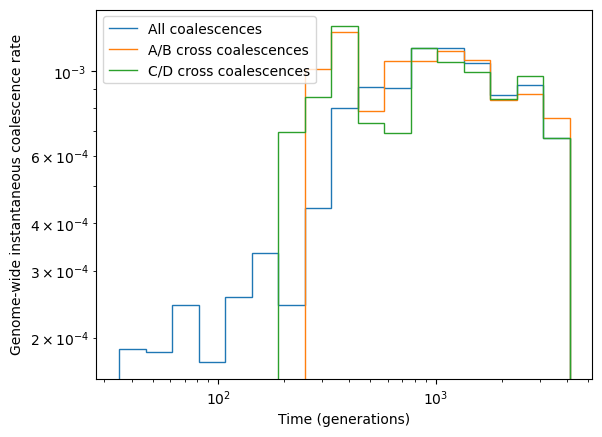

In [8]:
import numpy as np
num_timebins = 20 
time_breaks = np.concatenate(( # NB: first bin must start at sample time & last at infinity
    [0], np.logspace(np.log10(35), np.log10(ts.max_time/2), num_timebins - 2), [np.inf]
))

all_rates = ts.pair_coalescence_rates(time_windows=time_breaks)
plt.stairs(all_rates[1:-1], time_breaks[1:-1], label="All coalescences")

# Now calculate some cross coalescences
samples = {pop.metadata["name"]: ts.samples(pop.id) for pop in ts.populations()}
cross_AB_rates = ts.pair_coalescence_rates(sample_sets=[samples["A"], samples["B"]], time_windows=time_breaks)
cross_CD_rates = ts.pair_coalescence_rates(sample_sets=[samples["C"], samples["D"]], time_windows=time_breaks)
plt.stairs(cross_AB_rates[1:-1], time_breaks[1:-1], label="A/B cross coalescences")
plt.stairs(cross_CD_rates[1:-1], time_breaks[1:-1], label="C/D cross coalescences")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(f"Time ({ts.time_units})")
plt.ylabel(f"Genome-wide instantaneous coalescence rate")
plt.legend();

Like all other tskit statistics, we can window coalescence rates along the genome. Below you can see a burst of coalescence (red) at about 170 generations ago around 0.3Mb along the genome, with an absence of coalescence information (grey) within that population at more distant times for that genomic region. This is indicative of a selective sweep at that genomic location (particularly clear because of the cleanliness of simulated data).

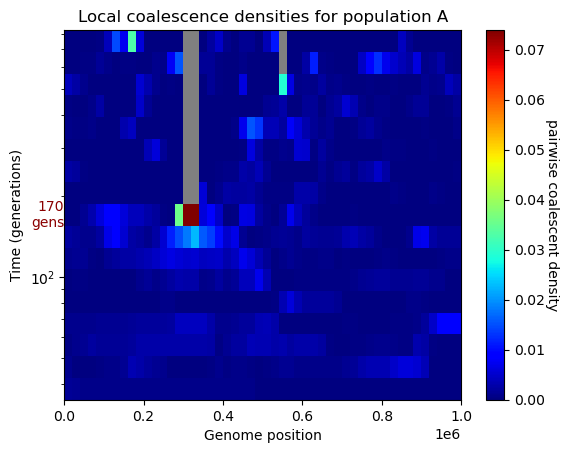

In [9]:
time_breaks = np.concatenate(( # NB: first bin must start at sample time & last at infinity
    [0], np.logspace(np.log10(35), np.log10(ts.max_time/10), num_timebins - 2), [np.inf]
))

popA_rates = ts.pair_coalescence_rates(time_windows=time_breaks, windows=genome_windows, sample_sets=[samples["A"]])
colourmap = plt.get_cmap('jet')
colourmap.set_bad(color='grey')
im = plt.pcolormesh(genome_windows, time_breaks[1:-1], popA_rates[:,1:-1].T, cmap=colourmap)
bar = plt.colorbar(im)
bar.ax.set_ylabel('pairwise coalescent density', labelpad=10, rotation=270)
plt.yscale("log")
plt.xlabel(f"Genome position")
plt.text(0, 170, "170\ngens", ha="right", va="center", c="darkred")
plt.ylabel(f"Time ({ts.time_units})")
plt.title("Local coalescence densities for population A");

## Tree plotting

_Tskit_ records ancestral trees along the genome. These can be easily plotted

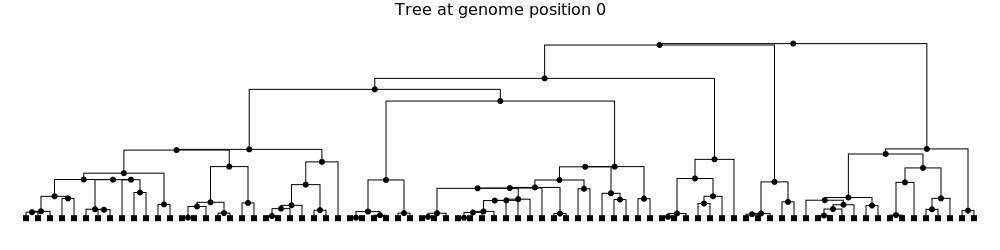

In [10]:
first_tree = ts.first()
display(first_tree.draw_svg(size=(1000, 250), title="Tree at genome position 0", node_labels={}))

_Tskit_ tree plots can be decorated using a variety of styles (see the [viz tutorial](https://tskit.dev/tutorials/viz.html)). Here we plot the tree at position 0.3 Mb, to see population A really does have a cluster of coalescences around 170 generations ago (at the dotted magenta line: it does!).

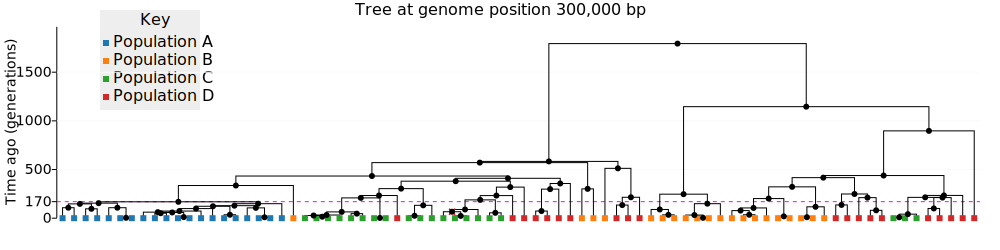

In [11]:
from matplotlib import colors
styles = [f".leaf.p{p.id}>.sym" + "{fill:" + colors.to_hex(f"C{p.id}") + "}" for p in ts.populations()]

legend = '<rect width="100" height="100" x="100" y="10" fill="#EEE" /><text x="140" y="25">Key</text>'
legend += "".join([  # The legend lines, one for each population.
    f'<g transform="translate(103, {40 + 18*p.id})" class="leaf p{p.id}">'  # an SVG group
    f'<rect width="6" height="6" class="sym" />'  # Square symbol
    f'<text x="10" y="7">Population {p.metadata["name"]}</text></g>'  # Label
    for p in ts.populations() if len(ts.samples(p.id)) > 0
])

display(ts.at(0.3e6).draw_svg(
    size=(1000, 250),
    node_labels={},    # Remove all node labels for a clearer viz
    mutation_labels={},
    style="".join(styles) + ".y-axis .tick:nth-child(2) .grid {stroke: magenta; stroke-dasharray: 4}",
    preamble=legend,
    y_axis=True,
    y_gridlines=True,
    y_ticks=[0, 170, 500, 1000, 1500],
    title="Tree at genome position 300,000 bp",
))

## Other analyses
This notebook is fully interactive. Feel free to run other analysis below. Tutorial material is avaiable at https://tskit.dev/tutorials/, and there are also other notebooks in this JupyterLite instance: View -> File Browser will reveal them on the right if they are not shown.

In [12]:
# Use this as a playground for trying out tskit
